In [39]:
import os
import time
import numpy as np
import pandas as pd
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from hyperopt import hp
from hyperopt.pyll import scope

from src.Services.DataProcessService import DataProcessService
from src.Services.LoadDataFrameService import LoadDataFrameService
from src.Services.HyperparameterOptimizationService import HyperparameterOptimizationService
from src.Visualizations.LearningCurveVisualizer import LearningCurveVisualizer
from src.Visualizations.PredictionRangeAccuracyVisualizer import PredictionVisualizationService

In [40]:
# MODEL_NAME = 'model_5_days_correct.keras'
MODEL_NAME = None
DATA_PATH = 'assets/crypto-data.csv'
SEQUENCE_LENGTH = 30
TEST_DAYS = 21
MODELS_DIR = os.path.join(os.curdir, "assets/models")
LOSS_METHOD = 'huber'

# Wczytanie danych

In [41]:
df = (LoadDataFrameService(DATA_PATH)).load_dataframe()

data_processor = DataProcessService(sequence_length=SEQUENCE_LENGTH, test_days=TEST_DAYS)

X_full, y_full = data_processor.create_sequences(df)
X_train, y_train, X_val, y_val, X_test, y_test = data_processor.split_data(X_full, y_full)

In [42]:
print(f"Test:       X={X_test.shape},  y={y_test.shape}")
print(f"Train:      X={X_train.shape}, y={y_train.shape}")
print(f"Validation: X={X_val.shape},   y={y_val.shape}")

Test:       X=(22, 30, 13),  y=(22, 3)
Train:      X=(2336, 30, 13), y=(2336, 3)
Validation: X=(259, 30, 13),   y=(259, 3)


# Model podstawowy


## Definiujemy model

In [43]:
def build_basic_dense_model(hparams):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])))

    for i in range(hparams['hidden_layers']):
        units = hparams[f'units_layer{i}']
        model.add(keras.layers.Dense(units))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation(hparams['activation']))  

    model.add(keras.layers.Dense(3))

    optimizer = keras.optimizers.get(hparams['optimizer'])
    optimizer.learning_rate = hparams['lr']

    model.compile(optimizer=optimizer, loss=LOSS_METHOD)
    return model

## Przestrzeń hiperparametrów

In [44]:
space = {
    'epochs': 20,
    'hidden_layers': hp.randint('num_layers', 3, 5),
    'units_layer0': hp.randint('units_layer0', 64, 1024),
    'units_layer1': hp.randint('units_layer1', 64, 1024),
    'units_layer2': hp.randint('units_layer2', 64, 1024),
    'units_layer3': hp.randint('units_layer3', 64, 1024), 
    'units_layer4': hp.randint('units_layer4', 64, 1024), 
    'activation': hp.choice('activation', ['relu', 'elu']),
    'optimizer': hp.choice('optimizer', ['adam', 'nadam', 'rmsprop']),
    'lr': hp.loguniform('lr', np.log(1e-5), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 32)),
}

## Szukamy najlepszego

In [45]:
if MODEL_NAME is None:
    optimizer_service = HyperparameterOptimizationService(X_train, y_train, X_val, y_val, build_basic_dense_model)
    best_params, best_model, trials = optimizer_service.optimize(space, max_evals=10)

    print("Najlepsze hiperparametry:")
    print(best_params)

Epoch 1/20                                            

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/home/piotr/.pyenv/versions/3.12.9/envs/tensorflow/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



 1/37 ━━━━━━━━━━━━━━━━━━━━ 19s 535ms/step - loss: 31091.2539
15/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30571.9785   
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30161.3691
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 30137.5195 - val_loss: 28456.2207

Epoch 2/20                                            

 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 32779.9414
16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29637.2266 
30/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29940.8672
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30015.9648 - val_loss: 28414.2695

Epoch 3/20                                            

 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 31038.5957
16/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30449.2207 
32/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30505.6387
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 30449.4395 - val_loss: 28365.5684

Epoch 4/20                                            

 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 26501.

## Budujemy wybrany już najlepszy model większą liczbą epok

In [46]:
model = None

if MODEL_NAME is None:
    model = best_model

    model.summary()
else:
    model = keras.models.load_model(f"{MODELS_DIR}/{MODEL_NAME}")

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_18 (Flatten)            │ (None, 390)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 231)            │        90,321 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 231)            │           924 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_60 (Activation)      │ (None, 231)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 804)            │       186,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_61          │ (None, 804)            │         3,216 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_61 (Activation)      │ (None, 804)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 386)            │       310,730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_62          │ (None, 386)            │         1,544 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_62 (Activation)      │ (None, 386)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 3)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,777,590 (6.78 MB)

 Trainable params: 591,582 (2.26 MB)

 Non-trainable params: 2,842 (11.10 KB)

 Optimizer params: 1,183,166 (4.51 MB)

In [47]:
model.layers

[<Flatten name=flatten_18, built=True>,
 <Dense name=dense_78, built=True>,
 <BatchNormalization name=batch_normalization_60, built=True>,
 <Activation name=activation_60, built=True>,
 <Dense name=dense_79, built=True>,
 <BatchNormalization name=batch_normalization_61, built=True>,
 <Activation name=activation_61, built=True>,
 <Dense name=dense_80, built=True>,
 <BatchNormalization name=batch_normalization_62, built=True>,
 <Activation name=activation_62, built=True>,
 <Dense name=dense_81, built=True>]

In [48]:
if MODEL_NAME is None:
    optimizer_name = best_params['optimizer']
    optimizer_class = getattr(tf.keras.optimizers, optimizer_name.capitalize())
    optimizer = optimizer_class(learning_rate=best_params['lr'])

    model.compile(optimizer=optimizer, loss=LOSS_METHOD)

In [49]:
model_id = time.strftime("model_%Y_%m_%d-%H_%M_%S")
model_path = f"{MODELS_DIR}/{model_id}.keras"

checkpoint_cb = keras.callbacks.ModelCheckpoint(model_path, save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=300, restore_best_weights=True)

class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nwalidacja/uczenie: {:.2f}".format(logs["val_loss"] / logs["loss"]))

print_val_train_ratio_cb = PrintValTrainRatioCallback()

In [50]:
history = None
if MODEL_NAME is None:
    history = model.fit(
        X_train,
        y_train,
        epochs=50,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[
            checkpoint_cb,
            early_stopping_cb,
            print_val_train_ratio_cb
        ]
    )

Epoch 1/50
66/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11583.6865
walidacja/uczenie: 1.28
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11518.1084 - val_loss: 13900.9082
Epoch 2/50
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9338.0781
walidacja/uczenie: 2.25
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9340.4043 - val_loss: 21111.2578
Epoch 3/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8925.1963
walidacja/uczenie: 1.72
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8940.1309 - val_loss: 15946.2656
Epoch 4/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8993.5791
walidacja/uczenie: 2.30
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8993.9746 - val_loss: 20732.7148
Epoch 5/50
71/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8387.3506
walidacja/uczenie: 2.28
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8400.9824 - val_loss: 19932.4453
Epoch 6/50
70/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8309.2100
walidacja/uczenie: 2.09
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss:

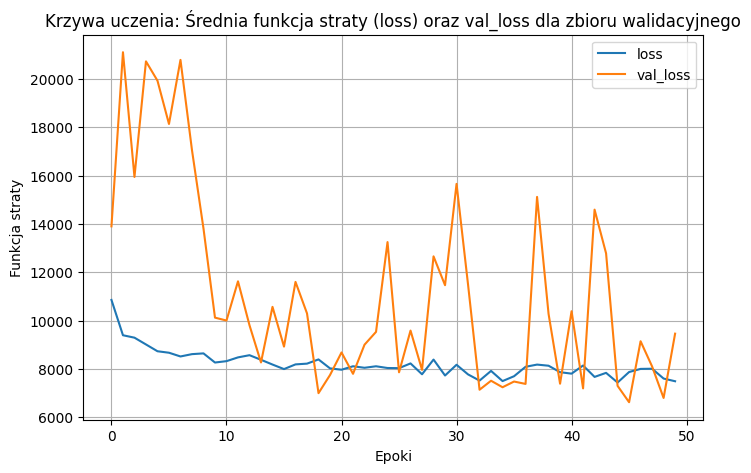

In [51]:
if history is not None:
    plot = LearningCurveVisualizer(history)
    plot.visualize()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


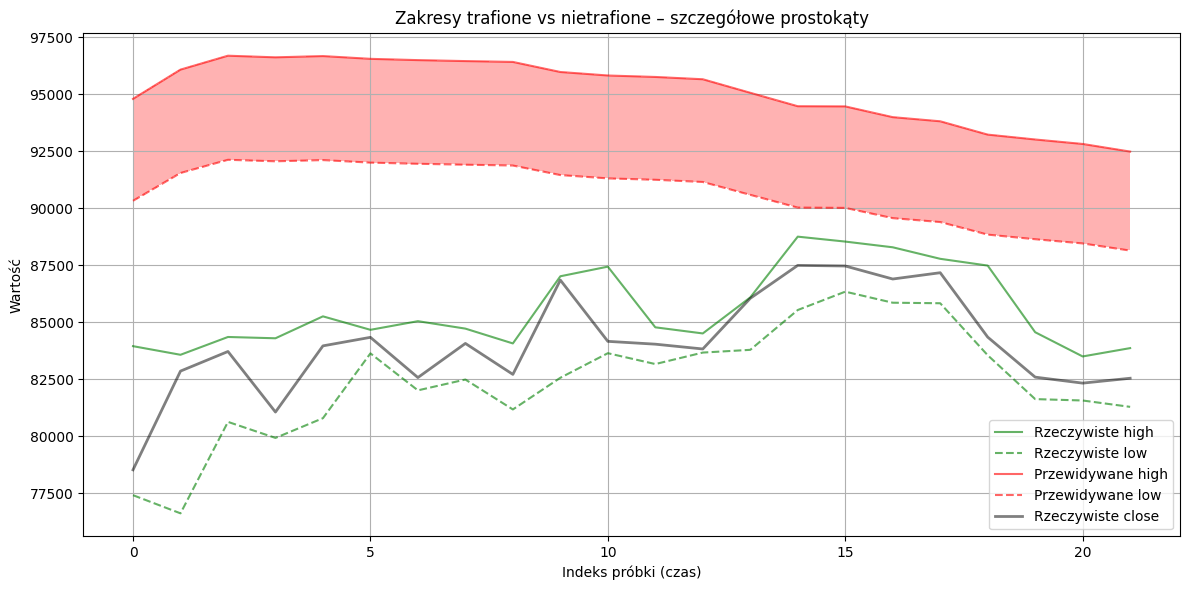

In [52]:
predictions = model.predict(X_test)
plot = PredictionVisualizationService(y_test, predictions)
plot.visualize()